In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot

from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")

plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
import yahoo_fin.stock_info as si
ticks = si.tickers_ftse100(True)
sp500 = si.tickers_sp500(True)
dow = si.tickers_dow(True)
nifty = si.tickers_nifty50(True)
display(ticks.head(100))


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


,Company,Ticker,FTSE industry classification benchmark sector[25]
0,3i,III,Financial services
1,Admiral Group,ADM,Insurance
2,Airtel Africa,AAF,Telecommunications services
3,Anglo American plc,AAL,Mining
4,Antofagasta plc,ANTO,Mining
...,...,...,...
95,Vistry Group,VTY,Home Construction
96,Vodafone Group,VOD,Mobile telecommunications
97,Weir Group,WEIR,Industrial goods and services
98,Whitbread,WTB,Retail hospitality


In [6]:
ticks_from_setctors = ticks.groupby('FTSE industry classification benchmark sector[25]',as_index=False).first().iloc[:,[2]]
ticks['FTSE industry classification benchmark sector[25]'].value_counts()

FTSE industry classification benchmark sector[25]
Financial services                                    7
Support services                                      7
Media                                                 6
Banks                                                 5
Household goods & home construction                   5
Mining                                                5
Pharmaceuticals & biotechnology                       4
Life insurance                                        4
Travel & leisure                                      4
Multiline utilities                                   4
Real estate investment trusts                         3
Food & drug retailing                                 3
Aerospace & defence                                   3
Retailers                                             3
Oil & gas producers                                   2
Tobacco                                               2
Telecommunications services                           

In [2]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-12-30'
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = '2024-10-01'

In [20]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER

df_dow = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = NAS_100_TICKER).fetch_data()
df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = HSI_50_TICKER).fetch_data()
df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DAX_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (108983, 8)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['XLNX']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 F

Shape of DataFrame:  (322496, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (177038, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DAI.DE']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 

Shape of DataFrame:  (100708, 8)


In [23]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')


In [3]:
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')

In [4]:
df_dow.drop(df_dow.columns[0], axis=1,inplace=True)
df_dow.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.454506,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,40.915886,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,32.906181,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.027210,7325600,CAT,0


In [4]:
ticks_list = df_dow['tic'].unique()

In [25]:
df_copy = df_dow.copy()
df_copy['symbol'] = df_dow['tic']
df_copy.head()
df_close = df_copy[['symbol','close','date']]
df_close.head()

,symbol,close,date
0,AAPL,6.454506,2010-01-04
1,AMGN,40.915886,2010-01-04
2,AXP,32.906181,2010-01-04
3,BA,43.777546,2010-01-04
4,CAT,40.027210,2010-01-04


In [26]:
pivot = df_close.pivot(index='date',values='close',columns='symbol')

pivot.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.454506,40.915886,32.906181,43.777546,40.027210,18.622328,16.475370,44.045532,27.715311,NaN,...,21.558409,23.347326,13.647313,39.663857,35.008789,25.299866,19.822807,14.697927,23.392054,13.113418
2010-01-05,6.465664,40.561455,32.833805,45.211334,40.505768,18.542681,16.401968,44.357536,27.646175,NaN,...,21.645786,23.354858,13.701604,39.676823,34.179432,25.259739,19.595650,14.724429,23.203924,12.982835
2010-01-06,6.362819,40.256641,33.364540,46.582806,40.628819,18.510326,16.295198,44.363091,27.499260,NaN,...,21.937040,23.211538,13.618073,39.488628,33.694481,25.508492,19.332523,14.301045,23.028326,12.953817
2010-01-07,6.351058,39.888027,33.905670,48.468555,40.792885,18.428192,16.368605,44.195957,27.507898,NaN,...,21.971994,22.970144,13.751725,39.274494,34.179432,26.487425,19.512436,14.215919,23.166283,12.961074
2010-01-08,6.393281,40.242458,33.881458,48.001007,41.250923,18.455570,16.455355,44.273952,27.551111,NaN,...,21.960333,23.128559,13.724578,39.222576,34.130222,26.238686,19.566416,14.224875,23.197649,12.895782


In [27]:
pivot[pivot.index>'2010-01-01'].plot(figsize=(10,4))

<Axes: xlabel='date'>

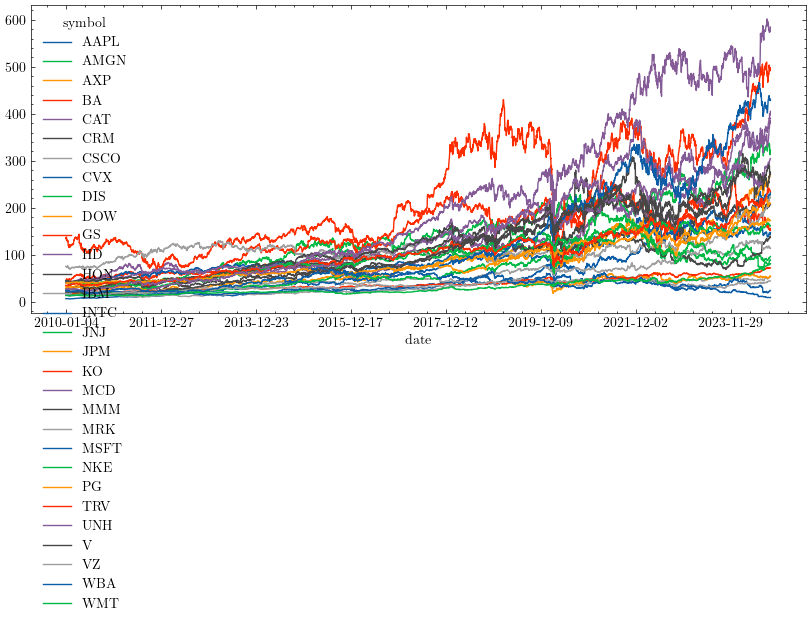

In [30]:
%matplotlib inline
plt.show()


In [68]:
df_dow.head()
df = df_dow.copy()

In [69]:
data = df.sort_values(['date','tic'],ignore_index=True)
data.index = data.index.factorize()[0]

In [70]:
df.head()
df.dropna(inplace=True)

In [71]:
INDICATORS = [
    "close_21_sma",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators


In [72]:
processed.head(100)


,date,open,high,low,close,volume,tic,day,close_21_sma
0,2010-01-04,7.622500,7.660714,7.585000,6.454506,493729600,AAPL,0,6.454506
3710,2010-01-04,56.630001,57.869999,56.560001,40.915886,5277400,AMGN,0,40.915886
7420,2010-01-04,40.810001,41.099998,40.389999,32.906181,6894300,AXP,0,32.906181
11130,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0,43.777546
14840,2010-01-04,57.650002,59.189999,57.509998,40.027210,7325600,CAT,0,40.027210
...,...,...,...,...,...,...,...,...,...
29683,2010-01-07,31.770000,31.860001,31.540001,27.507898,8202100,DIS,3,27.592161
33393,2010-01-07,174.320007,178.750000,173.949997,137.520828,8727400,GS,3,135.676739
37103,2010-01-07,28.860001,29.219999,28.730000,20.481888,12058200,HD,3,20.300774
40813,2010-01-07,38.554264,39.431362,38.211052,28.460951,10266533,HON,3,28.043119


# Env Creation for training and test

In [73]:
train_data = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 88


In [75]:
from FinRL.finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from agents.evn_mvo import StockPortfolioEnv

stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None
}


#Establish the training environment using StockTradingEnv() class
e_train_gym = PortfolioOptimizationEnv(df = train_data, **env_kwargs)

In [90]:
from FinRL.finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None
}


#Establish the training environment using StockTradingEnv() class
test = PortfolioOptimizationEnv(df = test_data, **env_kwargs)

# PPO training
### trainin PPO Models on the train set and plotting results

In [76]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
ppo_agernt = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/              |              |
|    fps             | 49           |
|    iterations      | 1            |
|    time_elapsed    | 41           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0030147838 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 6114980.5
Final accumulative portfolio value: 6.1149805
Maximum DrawDown: -0.32804309924753394
Sharpe ratio: 0.8813417485897913
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.52e+03     |
|    ep_rew_mean          | 1.81         |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2            

In [84]:
metrics_df = pd.DataFrame(
    {
        "date": e_train_gym._date_memory,
        "returns": e_train_gym._portfolio_return_memory,
        "rewards": e_train_gym._portfolio_reward_memory,
        "portfolio_values": e_train_gym._asset_memory["final"],
    }
)
metrics_df.head()

,date,returns,rewards,portfolio_values
0,2010-01-04,0.000000,0.000000,1.000000e+06
1,2010-01-05,-0.000191,-0.000191,9.998093e+05
2,2010-01-06,-0.001419,-0.001420,9.983907e+05
3,2010-01-07,0.004121,0.004113,1.002505e+06
4,2010-01-08,0.001210,0.001209,1.003718e+06


## Testing PPO on test set

In [118]:
stock_dimension = len(train_data.tic.unique())
stock_dimension

29

In [150]:
def DRL_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)

        if (
            i == max_steps - 1
        ):  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
            metrics_df = pd.DataFrame(
                {
                    "date": date_list,
                    "returns": environment._portfolio_return_memory,
                    "rewards": environment._portfolio_reward_memory,
                    "portfolio_values": environment._asset_memory["final"],
                }
            )
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,metrics_df

In [151]:

res = DRL_prediction(model_ppo, test)



Initial portfolio value:1000000
Final portfolio value: 1095993.5
Final accumulative portfolio value: 1.0959935
Maximum DrawDown: -0.060951047801831804
Sharpe ratio: 1.2134448758209773
hit end!


<Axes: xlabel='date'>

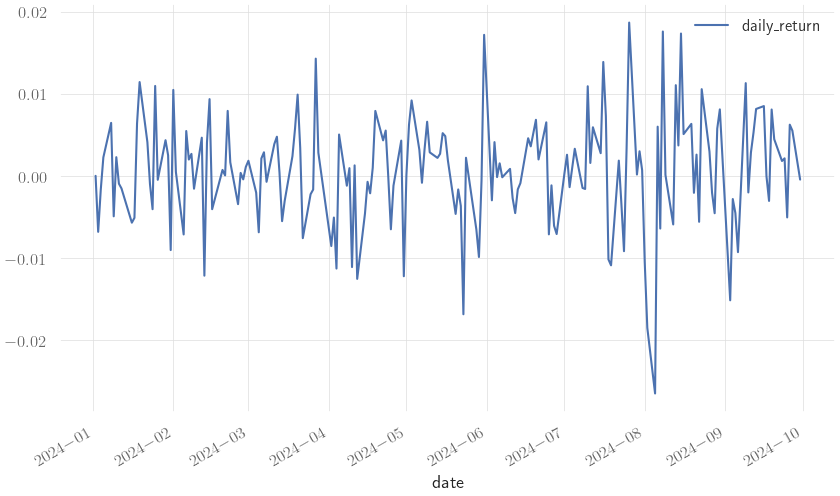

In [152]:
%matplotlib inline
plt.show()

acc = pd.DataFrame(res[0])
actions = pd.DataFrame(res[1])
metrics = pd.DataFrame(res[2])
acc.plot(x='date', y='daily_return')

<Axes: xlabel='date'>

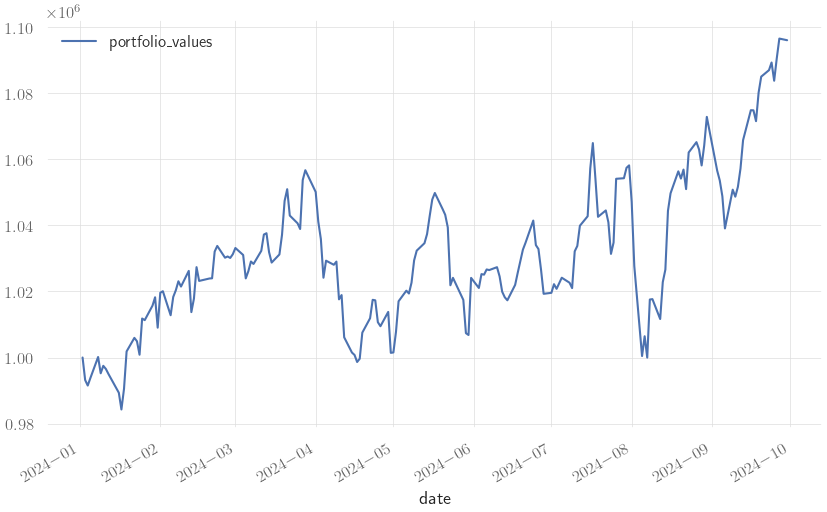

In [154]:
metrics.plot(x='date', y='portfolio_values')

In [149]:
test._asset_memory['final']

[1000000]

# Actor Advantage Critic

## Training The Model

# Buy and hold strategy

In [14]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
environment_train = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)
terminated = False

environment_train.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1048449.5
Final accumulative portfolio value: 1.0484495
Maximum DrawDown: -0.06429857349553114
Sharpe ratio: 0.7897540666800257


In [15]:
buy_and_hold_train = environment_train._asset_memory["final"]
buy_and_hold_weights_train = environment_train._final_weights
buy_and_hold_weights_df = pd.DataFrame(buy_and_hold_weights_train)
buy_and_hold_account_df = pd.DataFrame(buy_and_hold_train)
buy_and_hold_weights_df.drop(buy_and_hold_weights_df.columns[0],axis=1,inplace=True)
buy_and_hold_weights_df.columns = train_data.tic.unique()
buy_and_hold_weights_df.head(100)


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.035062,0.034124,0.034319,0.034455,0.034724,0.034529,0.034462,0.035091,0.034548,0.034356,...,0.034432,0.035529,0.034307,0.034512,0.034362,0.034754,0.034838,0.034261,0.033975,0.034654
2,0.034517,0.034253,0.034277,0.034856,0.035104,0.033568,0.033995,0.034560,0.034559,0.034468,...,0.034883,0.033877,0.034379,0.034567,0.034516,0.034722,0.034186,0.034349,0.034928,0.034400
3,0.034625,0.034665,0.034801,0.033898,0.034894,0.035128,0.034645,0.034375,0.034989,0.034153,...,0.034383,0.034480,0.034095,0.034369,0.034560,0.034141,0.034650,0.034789,0.034191,0.034508
4,0.034747,0.034386,0.034393,0.034529,0.034476,0.034389,0.034191,0.034548,0.034480,0.034664,...,0.034496,0.034617,0.034705,0.034413,0.034545,0.034723,0.034558,0.034316,0.034314,0.034287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.034480,0.034472,0.035029,0.034657,0.034112,0.034304,0.034500,0.035044,0.035008,0.035296,...,0.031020,0.034085,0.034752,0.032726,0.035435,0.034973,0.034589,0.034401,0.035026,0.034180
96,0.034979,0.034378,0.034539,0.035152,0.034914,0.034578,0.034684,0.034657,0.034425,0.034691,...,0.033828,0.034090,0.034713,0.034262,0.033840,0.034452,0.034799,0.034875,0.033640,0.034188
97,0.034272,0.035177,0.034256,0.032609,0.033378,0.034083,0.034094,0.033151,0.034618,0.034246,...,0.035069,0.034753,0.034386,0.035925,0.034149,0.034651,0.034890,0.035140,0.034680,0.035440
98,0.035397,0.034994,0.032837,0.033507,0.034026,0.033893,0.034614,0.034218,0.033841,0.033083,...,0.035582,0.034429,0.035232,0.036087,0.035567,0.036203,0.035242,0.035259,0.034173,0.034486


<Axes: >

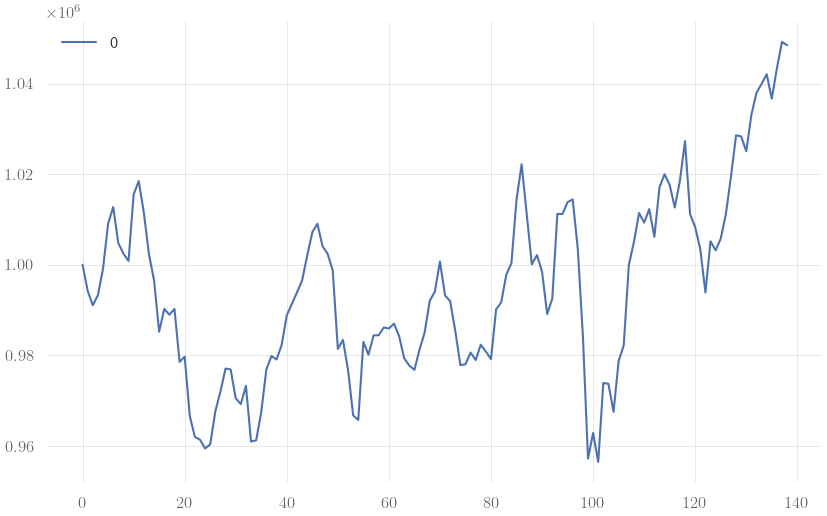

In [16]:
buy_and_hold_account_df.plot()

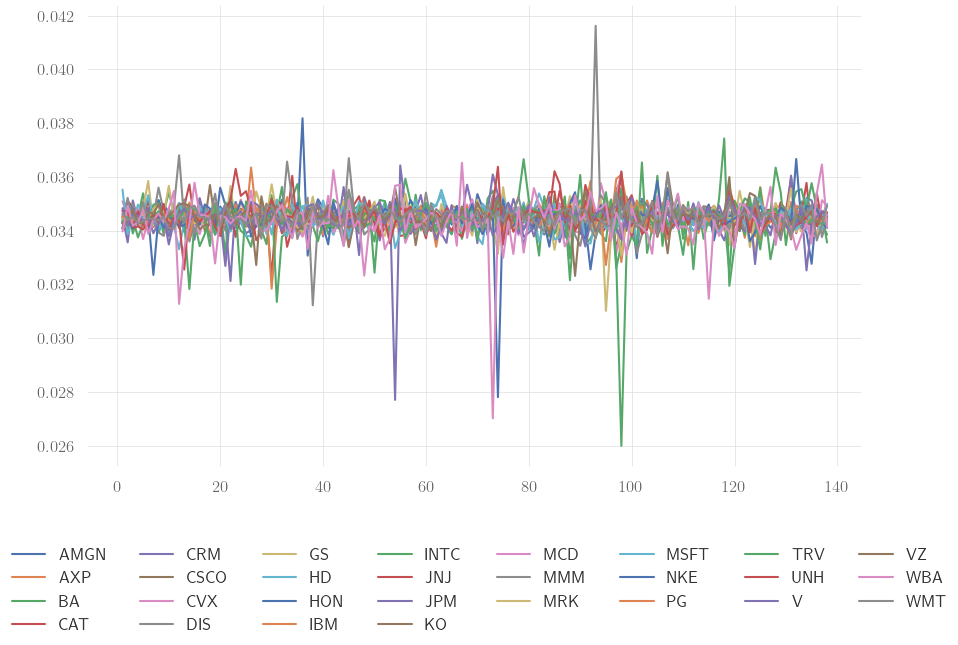

In [77]:
buy_and_hold_weights_df.head()
buy_and_hold_weights_df.iloc[1:,1:].plot().legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

In [18]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

In [19]:
states_ppo = e_train_gym.state_memory
states_ppo_dates = e_train_gym.date_memory
states = np.array(states_ppo)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
total_portfolio_value = holdings.sum(axis=1).reshape(-1, 1)

ppo_weights = holdings /total_portfolio_value
weights_df = pd.DataFrame(ppo_weights, columns=z2.columns[1:stock_dimension + 1].tolist())



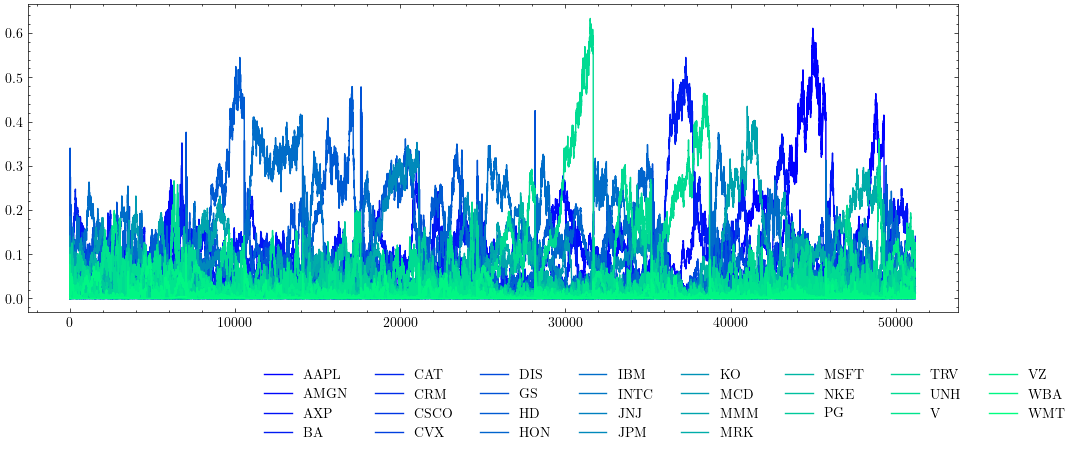

In [32]:
weights_df.plot(colormap="winter",figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

In [19]:
# add covariance matrix as states
df = df_dow.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

df["pct_change"] = df.groupby("tic").close.pct_change()

cov_list = []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    cov_list.append(covs)


In [20]:
df["mean_pct_change_lookback"] = df.rolling(lookback)["pct_change"].mean()
df["ewm_returns"] = df["pct_change"].ewm(span=50).mean()
df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list})
df = df.merge(df_cov, left_on='date',right_on='time')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

In [21]:
df.head(3)

,date,open,high,low,close,volume,tic,day,pct_change,mean_pct_change_lookback,ewm_returns,time,cov_list
0,2011-01-03,11.630000,11.795000,11.601429,9.939778,445138400,AAPL,0,0.021733,0.000879,0.000865,2011-01-03,"[[0.000284962291322476, 9.196054051092536e-05,..."
1,2011-01-03,55.200001,56.279999,55.180000,39.377647,5453300,AMGN,0,0.011840,0.000915,0.001296,2011-01-03,"[[0.000284962291322476, 9.196054051092536e-05,..."
2,2011-01-03,43.299999,43.619999,43.110001,35.531185,7633300,AXP,0,0.011183,0.000965,0.001683,2011-01-03,"[[0.000284962291322476, 9.196054051092536e-05,..."


# Mean Variance optimization

In [24]:

from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
)

stock_dimension = len(test_df.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
agent = MarkowitzAgent(e_test_gym)
markowitz_history_df = agent.prediction(e_test_gym)
markowitz_history_df["method"] = "markowitz"

Stock Dimension: 30, State Space: 30
begin_total_asset:1000000
end_total_asset:1188242.767554169
Sharpe:  1.88402923632786
Test Finished!
episode_return 1.1882427675541691


<Axes: xlabel='date'>

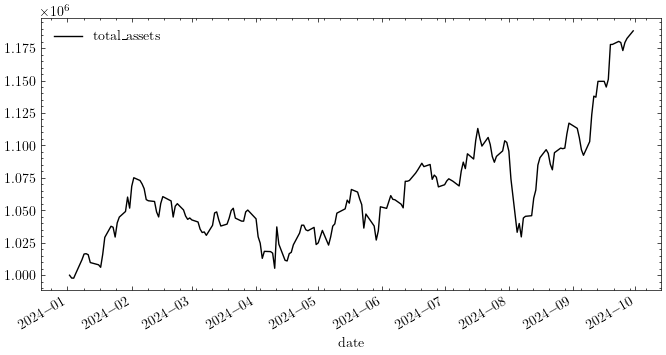

In [53]:
%matplotlib inline
markowitz_history_df.plot.line(x='date', y= 'total_assets',figsize=(8,4),color='black')

In [57]:
from stock_env import StockTradingEnv
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
env_kwargs = {
    "hmax": 100, 
    "num_stock_shares": [0] * stock_dimension,
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "make_plots" : False
    
}
e_test_gym = StockTradingEnv(df = test_data, **env_kwargs)

In [77]:
states_ppo = e_test_gym.state_memory
states = np.array(states_ppo)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
total_portfolio_value = holdings.sum(axis=1).reshape(-1, 1)

ppo_weights = holdings /total_portfolio_value
weights_df = pd.DataFrame(ppo_weights, columns=z2.columns[1:stock_dimension + 1].tolist())


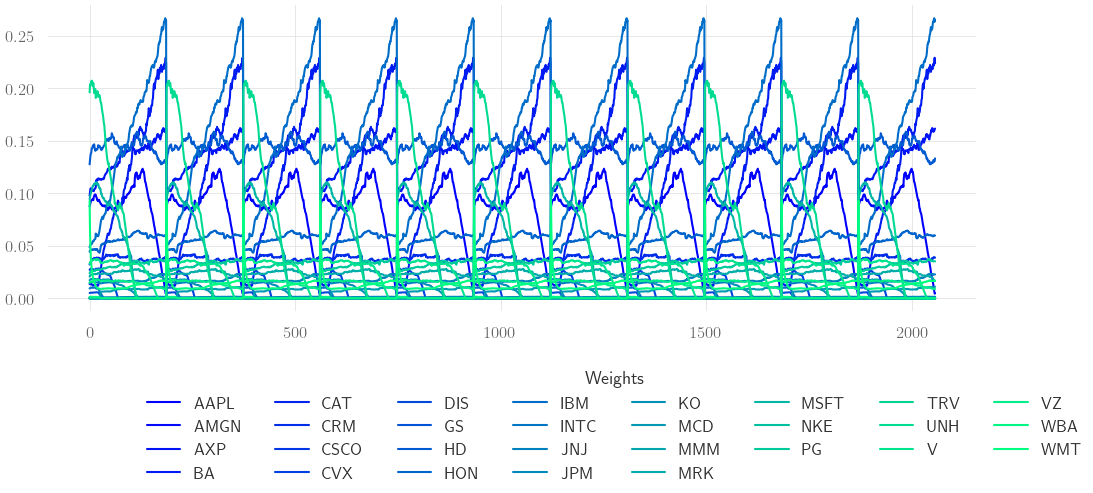

In [78]:
weights_df.plot(colormap="winter",figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0),title="Weights")


hit end!


<Axes: title={'center': '1 / N on test data'}>

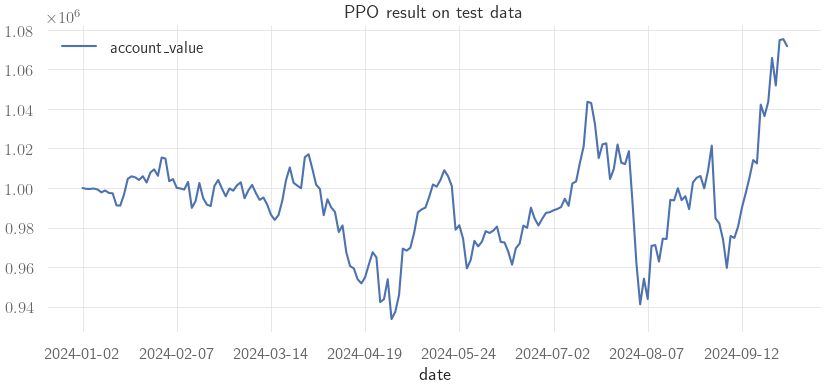

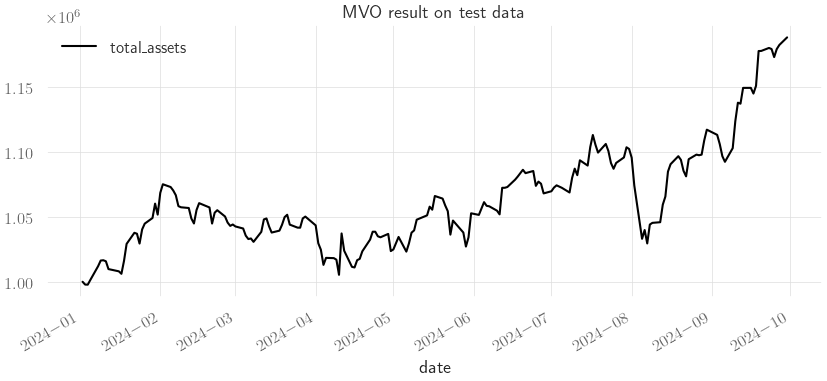

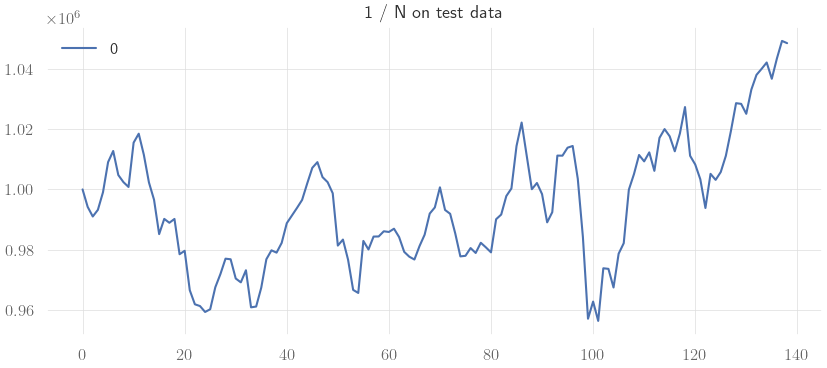

In [72]:
df_account_value_ppo_test, df_actions_ppo = DRLAgent.DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)
df_result_ppo = df_account_value_ppo_test.set_index(df_account_value_ppo_test.columns[0])
plt.rcParams["figure.figsize"] = (10,4)
df_result_ppo.plot(title="PPO result on test data")
markowitz_history_df.plot.line(x='date', y= 'total_assets',color='black',title="MVO result on test data")

buy_and_hold_account_df.plot(title="1 / N on test data")


# df_account_value_ppo_train, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=ppo_agernt, 
#     environment = e_train_gym)
# df_result_ppo = df_account_value_ppo_train.set_index(df_account_value_ppo_train.columns[0])
# plt.rcParams["figure.figsize"] = (10,4)
# df_result_ppo.plot()

In [59]:
e_train_gym.rewards_memory

[]

In [48]:
backtest_stats(df_account_value_ppo_train)

Annual return          0.140229
Cumulative returns     5.259409
Annual volatility      0.212230
Sharpe ratio           0.725599
Calmar ratio           0.259640
Stability              0.925054
Max drawdown          -0.540091
Omega ratio            1.153528
Sortino ratio          1.020412
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013090
Daily value at risk   -0.026127
dtype: float64


Annual return          0.140229
Cumulative returns     5.259409
Annual volatility      0.212230
Sharpe ratio           0.725599
Calmar ratio           0.259640
Stability              0.925054
Max drawdown          -0.540091
Omega ratio            1.153528
Sortino ratio          1.020412
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013090
Daily value at risk   -0.026127
dtype: float64

In [98]:
backtest_stats(df_account_value_ppo_test)

Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64


Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (167, 8)


<Axes: >

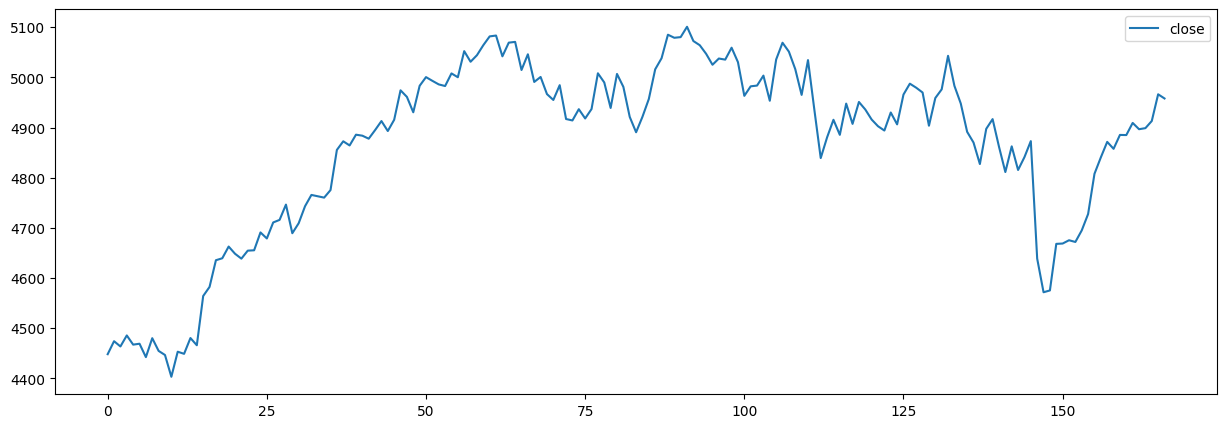

In [100]:
index_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3513, 8)


<Axes: >

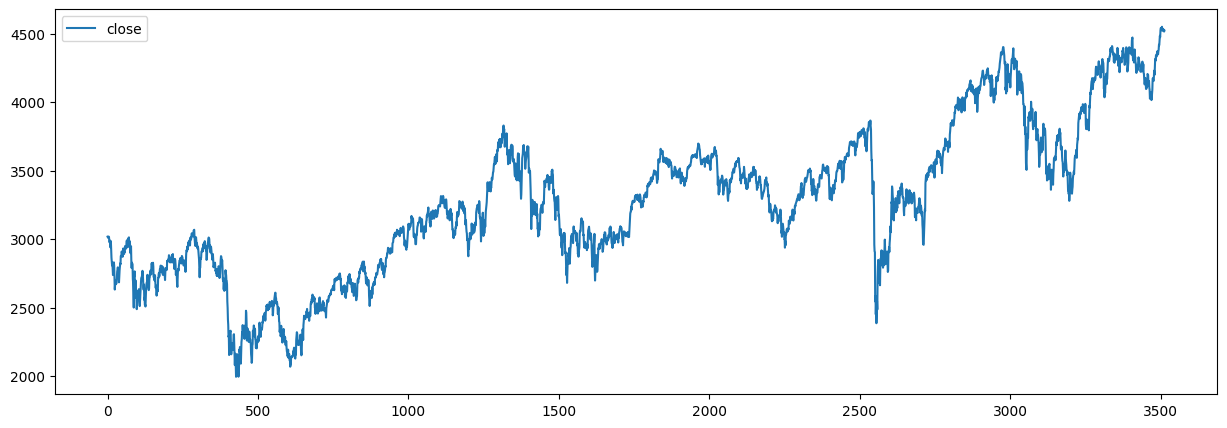

In [102]:
index_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

In [103]:
def DRL_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    state_memory= []

    test_env.reset()
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        state_memory.append(test_obs[0])

        if (
            i == max_steps - 1
        ):  # more descriptive condition for early termination to clarify the logic
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0],state_memory

In [104]:
df_account_value_ppo_test, df_actions_ppo, states = DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)

hit end!


In [105]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

print(len(columns))

22


In [114]:
states = np.array(states)
z = pd.DataFrame(states,columns= columns)
z.head()

,acc_value,ADM,AZN,BA,BP,NOK,SAP,VOD,ADM_holding,AZN_holding,...,NOK_holding,SAP_holding,VOD_holding,ADM_ma,AZN_ma,BA_ma,BP_ma,NOK_ma,SAP_ma,VOD_ma
0,987373.5000,71.248657,66.875084,243.910004,34.646816,3.290370,147.933578,8.427602,18.0,0.0,...,0.0,22.0,0.0,71.645844,63.820744,243.725662,34.138023,3.242162,153.708771,8.354484
1,974955.1875,69.904167,67.325356,244.940002,34.415836,3.348606,146.679321,8.522722,36.0,0.0,...,0.0,44.0,0.0,71.585434,63.983559,244.633331,34.134171,3.237633,153.551422,8.355597
2,962566.8125,68.988342,66.933815,249.000000,34.675690,3.338900,147.992844,8.541746,54.0,0.0,...,0.0,66.0,0.0,71.490608,64.117332,245.657669,34.143475,3.234721,153.464172,8.359751
3,950044.3750,69.231911,67.746262,229.000000,34.098244,3.435961,150.669250,8.570282,72.0,0.0,...,0.0,88.0,0.0,71.384407,64.300056,245.960663,34.148609,3.235045,153.444427,8.362921
4,938036.5625,68.851944,67.452614,225.759995,33.578537,3.377724,150.264328,8.484674,90.0,0.0,...,0.0,110.0,0.0,71.266525,64.443947,246.152664,34.118774,3.232780,153.377274,8.356263


In [107]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| time/                 |            |
|    fps                | 144        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -9.99      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -14.7      |
|    reward             | 0.05778634 |
|    std                | 1.01       |
|    value_loss         | 2.41       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 149       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000   

hit end!


<Axes: xlabel='date'>

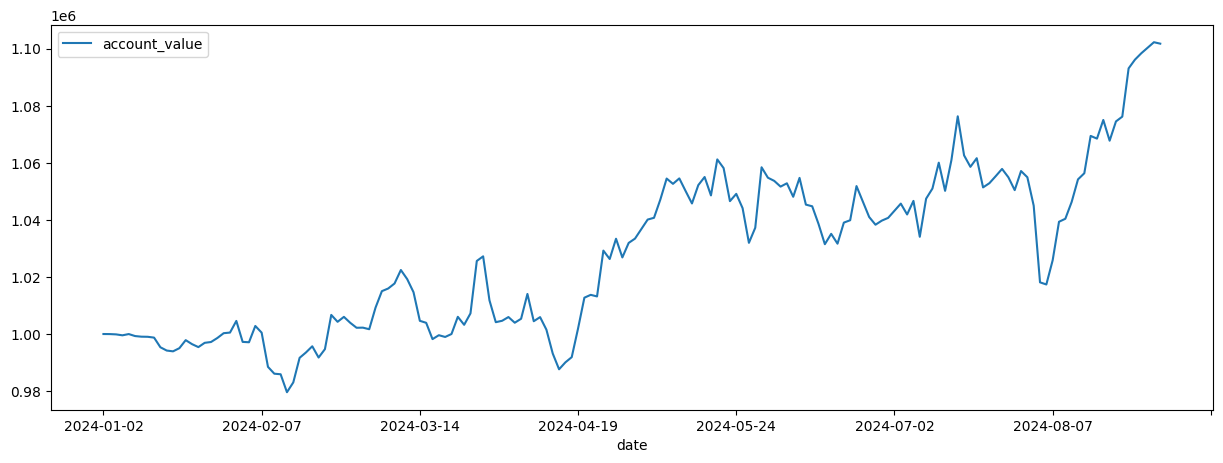

In [31]:

returns,actions = DRLAgent.DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot()

hit end!
day: 167, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1098160.60
total_reward: 98160.60
total_cost: 2630.14
total_trades: 705
Sharpe: 0.802
hit end!


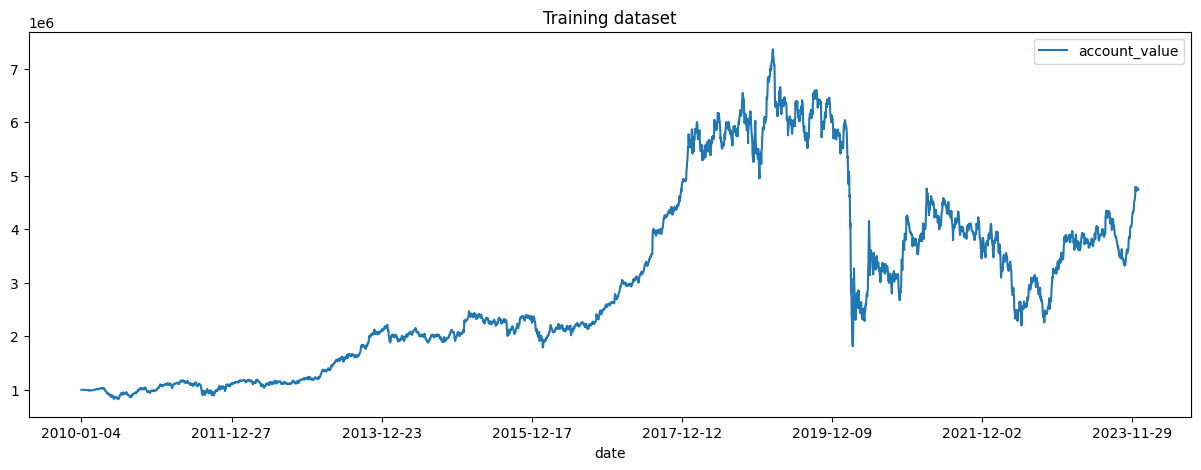

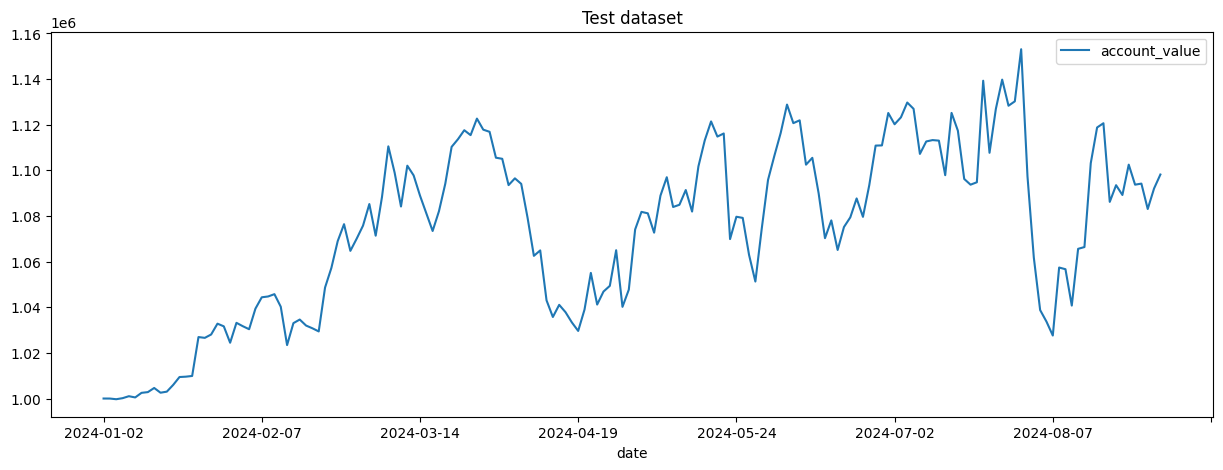

In [136]:
returns,actions,states = DRL_prediction(model=trained_a2c, 
                             environment=e_train_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot(title = 'Training dataset')
returns,actions,states_test = DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
ax = df_a2c.plot(title = 'Test dataset')